# Loading the data

This section of te code is in charge of loading the data. The data was obtained using the library of quandl, which is a free source of financial data. In here we specified the start and end datetime, and load the data from that specified datetime. The 

In [7]:
####### THIS SECTION LOADS THE DATA FROM QUANDL###########
import pandas as pd
import numpy as np
np.set_printoptions(threshold=np.inf)
import quandl
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# We will look at stock prices over the past year
start = datetime.datetime(2003,1,1)
end = datetime.date.today()

# This is a list of different sources for data that quandl uses
y = ["WGC/","LBMA/", "JOHNMATT/", "USTREASURY/"]

# This is a list of data we want from the specified data scource
s = ["GOLD_DAILY_USD", "SILVER", "PALL", "REALYIELD"]

# Initialzing our variable stockIndex, and indicating that it's a pandas dataframe
stockIndex = pd.DataFrame()

# A for loop that goes through the list and does a request to quandl and
# the data is saved in the stockIndex varialble
for indx, a in enumerate(y):
    dummy = quandl.get(a + s[indx], start_date=start, end_date=end)
    stockIndex = pd.concat([stockIndex, dummy], axis=1, sort=False)

# In this section we clean the data. We drop all the extra data that we don't want
# and also we drop all the rows, where at least in column have NaN values
stockIndex = stockIndex.drop(['GBP', 'EURO', 'Hong Kong 8:30', 'Hong Kong 14:00', 'London 09:00'], axis=1)
stockIndex = stockIndex.dropna()

# We rename the columns
stockIndex.rename(columns={"Value":"Gold",
                         "USD":"Silver Price",
                         "New York 9:30":"Palladium Price",
                         "5 YR":"USA Bond 5yr",
                         "7 YR":"USA Bond 7yr",
                         "10 YR":"USA Bond 10yr",
                         "20 YR":"USA Bond 20yr",
                         "30 YR":"USA Bond 30yr"},
                  inplace=True)

print("The data is loaded")

The data is loaded


# Looking at the correlation

Before we porcess the data, we need to look how the data is correlated the price of gold. As we mention in the report, and based on the reference we have used, 7 major indeces were used. These indeces are Silver, Palladium, and the USA interest bond rates. We can see in the the table that these indeces have a strong correlation with the price of gold.

In [8]:
correlation = stockIndex.corr(method="pearson")
correlation.style

,Gold,Silver Price,Palladium Price,USA Bond 5yr,USA Bond 7yr,USA Bond 10yr,USA Bond 20yr,USA Bond 30yr
Gold,1,0.89008,-0.0675489,-0.816494,-0.790832,-0.669766,-0.450964,-0.357363
Silver Price,0.89008,1,-0.156285,-0.713817,-0.601006,-0.41325,-0.119264,0.00316886
Palladium Price,-0.0675489,-0.156285,1,0.351469,0.28641,0.116746,-0.101061,-0.170832
USA Bond 5yr,-0.816494,-0.713817,0.351469,1,0.963621,0.859708,0.595527,0.469049
USA Bond 7yr,-0.790832,-0.601006,0.28641,0.963621,1,0.952032,0.761771,0.664054
USA Bond 10yr,-0.669766,-0.41325,0.116746,0.859708,0.952032,1,0.916992,0.844025
USA Bond 20yr,-0.450964,-0.119264,-0.101061,0.595527,0.761771,0.916992,1,0.980983
USA Bond 30yr,-0.357363,0.00316886,-0.170832,0.469049,0.664054,0.844025,0.980983,1


# Plot the data

Populating the interactive namespace from numpy and matplotlib


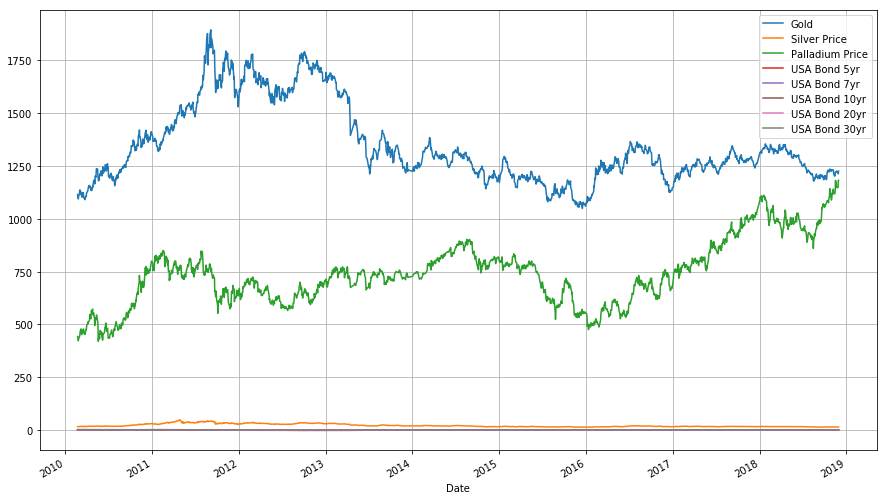

In [9]:
######### THIS SECTION PLOT THE DATA ###########################

# This line is necessary for the plot to appear in a Jupyter notebook
%matplotlib inline

# Control the default size of figures in this Jupyter notebook
%pylab inline

pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots

stockIndex.plot(y=["Gold", "Silver Price", "Palladium Price", "USA Bond 5yr", "USA Bond 7yr", "USA Bond 10yr", "USA Bond 20yr", "USA Bond 30yr"], grid=True)


# Separating our data

In this part, we separate our data and transform it into a numpy array that is going to be used in the neural network. Our label data will be saved in the variable "Y" and the features will be saved in the variable "X". This is done in order to be more consistent with the theory that we have been learned in class.

In [10]:
Y = stockIndex.Gold.values
Y = Y.reshape((len(Y), 1))
X = stockIndex.drop(['Gold'],axis=1).values
print("The label data have the size of {}".format(Y.shape))
print("The feature data have the size of {}".format(X.shape))

The label data have the size of (1995, 1)
The feature data have the size of (1995, 7)


# Implementing the Neural Network

This section is the implementation of our Neural Network. The neural network was done using Keras, which is a wrapper for developing neural networks with tensor flow. The process is as follow: first we create a function were it is the neural network. Once the model is completed, a pipeline is created with a series of steps that the algorithm needs to do before processing the data. The first step that is done, and one of the most important parts, is scaling of the data. Before the data is processed, it needs to be in the same scale. The reason for this can be seen in the plot of the indices, where there is a big difference between the values. If the analysis is done without this process, the hypothesis can find a fit, but it won'tbe able to represent the data.

The second step of the process is the implementation of the neural network. However, it is important to describe how this process was implemented. Te actual fit of the neural network was not done in keras, but in Scikit. The KerasRegressor is a wrapper for Scikit. In here we are wrapping the function where our neural network is, along with the number of epochs to be processed, and the batch size. These steps are saved in a list, and then they are sent to the Scikit class Pipeline. In here, Pipeline is our whole function to implement the neural network, where it transforms the data, processes it, and transforms it back to the original values.

For the last step, instead of separating our data into test and train, we decided to implement the k-fold cross validation prediction and use the entire data set. The k-fold, is a class of Scikit where we indicate how many splits will separate the dataset, along if we want to use a random state, and shuffle the whole data. We decided to not implement the random state, since we had observed a problem with the result. This is due since it can generate a very small train data set, and a large test set, creating a bad training for that section of the split. Once the class is created, we use the function cross_val_predict, where we send the pipeline, the k-fold class, the features, and the label. This function does the fit and the prediction of the whole neural network.

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.constraints import maxnorm
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Baseline_model is a function were we save our Neural Network, and compile it when the function 
# is called. The value to return is the model once it completes
def baseLine_model():
    
    # Initialization of the Neural Network
    model = Sequential()
    
    # Variable where the number of hidden layers is specified
    hiddenLayer = 30
    
    # Create the input layer
    model.add(Dense(50, input_dim=7, kernel_initializer='normal', activation='relu'))
    
    # For loop where the number of hidden layers is created with the number specified
    for i in range(hiddenLayer):
        #model.add(Dropout(0.2))
        model.add(Dense(50, kernel_initializer='normal', activation='relu'))
    
    # Add the output layer
    model.add(Dense(1, kernel_initializer='normal'))
    
    # Compilation. We use for the loss function the mean-squared error and ADAM aptimizer
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # Return the model
    return model

# Standarized the data
# In this part we are creating a pipeline of a series of steps that
# cross_validation_function needs to do. First we standarize the data,
# then after the data have been standarized, we run the neural network

# Pipeline creation
estimators = []
estimators.append(('standardize', MinMaxScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseLine_model, epochs=16, batch_size=20, verbose=True)))
pipeline = Pipeline(estimators)

# Prediction using the k-fold cross validation prediction
kfold_stand = KFold(n_splits=50, random_state=None, shuffle=False)
prediction = cross_val_predict(pipeline, X, Y, cv=kfold_stand)


Epoch 1/16
1955/1955 [==============================] - 8s 4ms/step - loss: 1199223.7853
Epoch 2/16
1955/1955 [==============================] - 2s 864us/step - loss: 38555.9041
Epoch 3/16
1955/1955 [==============================] - 2s 905us/step - loss: 23550.0085
Epoch 4/16
1955/1955 [==============================] - 2s 888us/step - loss: 3689.4886
Epoch 5/16
1955/1955 [==============================] - 2s 852us/step - loss: 3009.6383
Epoch 6/16
1955/1955 [==============================] - 2s 857us/step - loss: 2991.7242
Epoch 7/16
1955/1955 [==============================] - 2s 857us/step - loss: 2697.7607
Epoch 8/16
1955/1955 [==============================] - 2s 849us/step - loss: 2601.7926
Epoch 9/16
1955/1955 [==============================] - 2s 866us/step - loss: 2618.8580
Epoch 10/16
1955/1955 [==============================] - 2s 844us/step - loss: 2682.1646
Epoch 11/16
1955/1955 [==============================] - 2s 862us/step - loss: 2629.6650
Epoch 12/16
1955/1955 [====

1955/1955 [==============================] - 2s 987us/step - loss: 2443.9014
Epoch 11/16
1955/1955 [==============================] - 2s 964us/step - loss: 2864.4792
Epoch 12/16
1955/1955 [==============================] - 2s 978us/step - loss: 3206.9542
Epoch 13/16
1955/1955 [==============================] - 2s 982us/step - loss: 2862.8810
Epoch 14/16
1955/1955 [==============================] - 2s 949us/step - loss: 2270.2384
Epoch 15/16
1955/1955 [==============================] - 2s 951us/step - loss: 2707.1576
Epoch 16/16
40/40 [==============================] - 3s 68ms/step
Epoch 1/16
1955/1955 [==============================] - 10s 5ms/step - loss: 1179616.1285
Epoch 2/16
1955/1955 [==============================] - 2s 962us/step - loss: 38801.0700
Epoch 3/16
1955/1955 [==============================] - 2s 964us/step - loss: 8315.2809
Epoch 4/16
1955/1955 [==============================] - 2s 974us/step - loss: 2910.7552
Epoch 5/16
1955/1955 [==============================] - 2

1955/1955 [==============================] - 2s 1ms/step - loss: 16948.8482
Epoch 4/16
1955/1955 [==============================] - 2s 1ms/step - loss: 2977.1054
Epoch 5/16
1955/1955 [==============================] - 2s 1ms/step - loss: 2869.7520
Epoch 6/16
1955/1955 [==============================] - 2s 1ms/step - loss: 2708.6411
Epoch 7/16
1955/1955 [==============================] - 2s 1ms/step - loss: 2661.7800
Epoch 8/16
1955/1955 [==============================] - 2s 1ms/step - loss: 2694.2562
Epoch 9/16
1955/1955 [==============================] - 2s 1ms/step - loss: 2457.0932
Epoch 10/16
1955/1955 [==============================] - 2s 1ms/step - loss: 2388.0972
Epoch 11/16
1955/1955 [==============================] - 2s 1ms/step - loss: 2484.1194
Epoch 12/16
1955/1955 [==============================] - 2s 1ms/step - loss: 2438.4126
Epoch 13/16
1955/1955 [==============================] - 2s 1ms/step - loss: 2135.2893
Epoch 14/16
1955/1955 [==============================] - 2s 

1955/1955 [==============================] - 2s 1ms/step - loss: 1858.3914
Epoch 15/16
1955/1955 [==============================] - 2s 1ms/step - loss: 1841.4748
Epoch 16/16
40/40 [==============================] - 4s 106ms/step
Epoch 1/16
1955/1955 [==============================] - 13s 7ms/step - loss: 1322032.7388
Epoch 2/16
1955/1955 [==============================] - 2s 1ms/step - loss: 35933.3231
Epoch 3/16
1955/1955 [==============================] - 2s 1ms/step - loss: 21581.6126
Epoch 4/16
1955/1955 [==============================] - 2s 1ms/step - loss: 3311.4550
Epoch 5/16
1955/1955 [==============================] - 2s 1ms/step - loss: 2878.0963
Epoch 6/16
1955/1955 [==============================] - 2s 1ms/step - loss: 3107.6757
Epoch 7/16
1955/1955 [==============================] - 2s 1ms/step - loss: 2829.1424
Epoch 8/16
1955/1955 [==============================] - 2s 1ms/step - loss: 2906.4811
Epoch 9/16
1955/1955 [==============================] - 2s 1ms/step - loss: 2

1955/1955 [==============================] - 2s 1ms/step - loss: 2403.6377
Epoch 9/16
1955/1955 [==============================] - 2s 1ms/step - loss: 2213.9395
Epoch 10/16
1955/1955 [==============================] - 2s 1ms/step - loss: 2322.9133
Epoch 11/16
1955/1955 [==============================] - 2s 1ms/step - loss: 2067.3642
Epoch 12/16
1955/1955 [==============================] - 2s 1ms/step - loss: 2436.9556
Epoch 13/16
1955/1955 [==============================] - 2s 1ms/step - loss: 1921.3421
Epoch 14/16
1955/1955 [==============================] - 2s 1ms/step - loss: 2056.0273
Epoch 15/16
1955/1955 [==============================] - 2s 1ms/step - loss: 2057.7302
Epoch 16/16
40/40 [==============================] - 5s 137ms/step
Epoch 1/16
1955/1955 [==============================] - 16s 8ms/step - loss: 1163440.3198
Epoch 2/16
1955/1955 [==============================] - 2s 1ms/step - loss: 39173.4311
Epoch 3/16
1955/1955 [==============================] - 2s 1ms/step - los

1955/1955 [==============================] - 2s 1ms/step - loss: 37757.1973
Epoch 3/16
1955/1955 [==============================] - 2s 1ms/step - loss: 12320.6511
Epoch 4/16
1955/1955 [==============================] - 2s 1ms/step - loss: 3087.0258
Epoch 5/16
1955/1955 [==============================] - 2s 1ms/step - loss: 3075.0450
Epoch 6/16
1955/1955 [==============================] - 3s 1ms/step - loss: 2511.1868
Epoch 7/16
1955/1955 [==============================] - 3s 1ms/step - loss: 2516.9514
Epoch 8/16
1955/1955 [==============================] - 3s 1ms/step - loss: 2684.0369
Epoch 9/16
1955/1955 [==============================] - 3s 1ms/step - loss: 2446.7061
Epoch 10/16
1955/1955 [==============================] - 3s 1ms/step - loss: 2094.4555
Epoch 11/16
1955/1955 [==============================] - 2s 1ms/step - loss: 2145.8610
Epoch 12/16
1955/1955 [==============================] - 3s 1ms/step - loss: 2294.1622
Epoch 13/16
1955/1955 [==============================] - 2s 

1955/1955 [==============================] - 3s 1ms/step - loss: 2258.4429
Epoch 14/16
1955/1955 [==============================] - 3s 1ms/step - loss: 2248.2466
Epoch 15/16
1955/1955 [==============================] - 3s 1ms/step - loss: 2987.5682
Epoch 16/16
40/40 [==============================] - 8s 189ms/step
Epoch 1/16
1955/1955 [==============================] - 22s 11ms/step - loss: 1134314.5760
Epoch 2/16
1955/1955 [==============================] - 3s 1ms/step - loss: 32977.5751
Epoch 3/16
1955/1955 [==============================] - 3s 1ms/step - loss: 3810.6969
Epoch 4/16
1955/1955 [==============================] - 3s 1ms/step - loss: 2780.4566
Epoch 5/16
1955/1955 [==============================] - 3s 1ms/step - loss: 3300.6755
Epoch 6/16
1955/1955 [==============================] - 3s 1ms/step - loss: 3454.2151
Epoch 7/16
1955/1955 [==============================] - 3s 1ms/step - loss: 2842.7520
Epoch 8/16
1955/1955 [==============================] - 3s 1ms/step - loss: 

1955/1955 [==============================] - 3s 1ms/step - loss: 2767.1751
Epoch 8/16
1955/1955 [==============================] - 3s 1ms/step - loss: 2995.2669
Epoch 9/16
1955/1955 [==============================] - 3s 1ms/step - loss: 2689.5959
Epoch 10/16
1955/1955 [==============================] - 3s 1ms/step - loss: 2330.9120
Epoch 11/16
1955/1955 [==============================] - 3s 1ms/step - loss: 2815.8571
Epoch 12/16
1955/1955 [==============================] - 3s 1ms/step - loss: 2863.7546
Epoch 13/16
1955/1955 [==============================] - 3s 1ms/step - loss: 2085.1639
Epoch 14/16
1955/1955 [==============================] - 3s 1ms/step - loss: 2236.5804
Epoch 15/16
1955/1955 [==============================] - 3s 2ms/step - loss: 1910.9388
Epoch 16/16
40/40 [==============================] - 9s 229ms/step
Epoch 1/16
1955/1955 [==============================] - 25s 13ms/step - loss: 1289916.6394
Epoch 2/16
1955/1955 [==============================] - 3s 2ms/step - los

1956/1956 [==============================] - 28s 14ms/step - loss: 1312953.3827
Epoch 2/16
1956/1956 [==============================] - 3s 2ms/step - loss: 38972.5805
Epoch 3/16
1956/1956 [==============================] - 3s 1ms/step - loss: 18048.4111
Epoch 4/16
1956/1956 [==============================] - 3s 1ms/step - loss: 3068.5544
Epoch 5/16
1956/1956 [==============================] - 3s 1ms/step - loss: 3080.5038
Epoch 6/16
1956/1956 [==============================] - 3s 2ms/step - loss: 3198.0796
Epoch 7/16
1956/1956 [==============================] - 3s 2ms/step - loss: 2754.6405
Epoch 8/16
1956/1956 [==============================] - 3s 2ms/step - loss: 2912.5481
Epoch 9/16
1956/1956 [==============================] - 3s 2ms/step - loss: 2569.9352
Epoch 10/16
1956/1956 [==============================] - 3s 2ms/step - loss: 2472.3499
Epoch 11/16
1956/1956 [==============================] - 3s 2ms/step - loss: 2390.7445
Epoch 12/16
1956/1956 [==============================] -

# Printing the Metric to evaluate our Neural Network

In [14]:
# Library for calculating the metrics for Regression
import sklearn.metrics as metrics

print("The Variance is {}".format(metrics.explained_variance_score(Y, prediction)))
print("The MSE is {}".format(metrics.mean_squared_error(Y, prediction)))
print("The MAE is {}".format(metrics.mean_absolute_error(Y, prediction)))
print("The MSLE is {}".format(metrics.mean_squared_log_error(Y, prediction)))
print("The Median Absolute Error is {}".format(metrics.median_absolute_error(Y, prediction)))
print("The R^2 is {}".format(metrics.r2_score(Y, prediction)))

The Variance is 0.9206335845259652
The MSE is 2858.2550461613973
The MAE is 39.256938990542764
The MSLE is 0.0014816904001795405
The Median Absolute Error is 27.696582031250045
The R^2 is 0.9205907260924545


# Plotting the predicted value with the original value

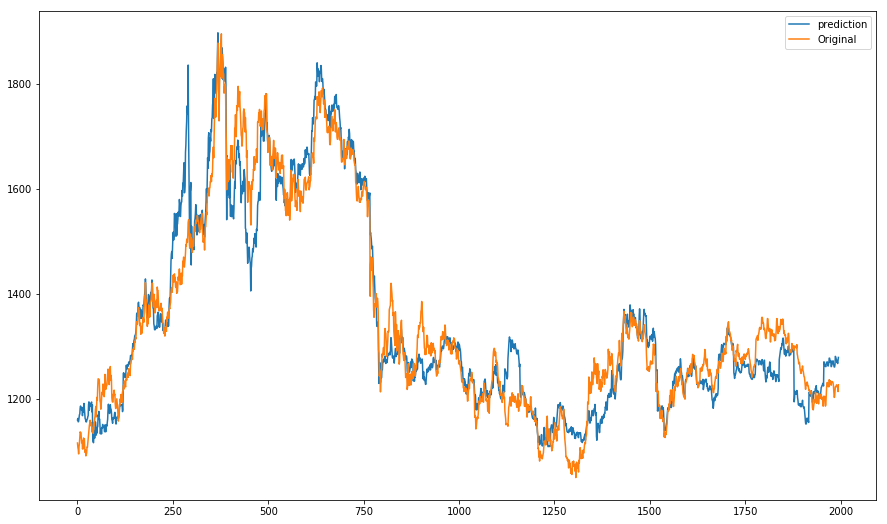

In [16]:
plt.plot(prediction)
plt.plot(Y)
plt.legend(["prediction", "Original"], loc="upper right")